In [ ]:
# using Pkg 
# Pkg.add("LiteQTL")
# Pkg.add("CSV")
# Pkg.add("DelimitedFiles")
# Pkg.add("DataFrames")

In [14]:
using LiteQTL 
using CSV 
using DelimitedFiles
using DataFrames
using StatsBase

In [12]:
function filter_maf(genotype::Array{Float32, 2})
    alleles = 2
    maf_threshold = Float32(0.05)
    
    af = sum(genotype, dims=1) ./ (alleles * size(genotype, 1))
    maf = replace(x -> x > 0.5 ? 1-x : x, af)

    if maf_threshold > 0 
        mask = getindex.(findall(maf .>= maf_threshold), 1)
        genotype = genotype[:, mask]
    end
    return genotype
end


filter_maf (generic function with 1 method)

In [13]:
function center_normalize(mat, dims=1)
    newmat = mat .- mean(mat, dims=dims)
    return newmat ./ sqrt.(sum(newmat.^2, dims=dims))
end

function calculate_r_tensor(geno, pheno; has_covar=false)
    # remove mean from geno and pheno
    if has_covar
        pheno = pheno.mean(dims = 1) 
        geno = geno.mean(dims = 1)
    end
    return center_normalize(pheno, 1)' * center_normalize(geno, 1)
end

calculate_r_tensor (generic function with 1 method)

In [5]:

function get_standardized_matrix_gpu(m::AbstractArray{<:Real,2})
    return (m .- mean(m, dims=1)) ./ std(m, corrected=false, dims=1) 
end

function get_standardized_matrix(mat::AbstractArray{<:Real,2})
    m = mat
    Threads.@threads for col in 1:size(m)[2]
        summ = 0.0f0
        rows = size(m)[1]
        for row in 1:rows
            summ += m[row, col]
        end
        mean = summ/rows
        sums = 0.0f0
        for row in 1:rows
            sums += (m[row,col] - mean)^2
        end
        std = sqrt(sums/rows)
        for row in 1:rows
            m[row,col] = (m[row,col]-mean)/std
        end
    end
    return m
end

get_standardized_matrix (generic function with 1 method)

In [6]:
pheno_file = "../../data/tensorqtldata/cleanpheno.csv"
geno_file = "../../data/tensorqtldata/chr9.csv"
export_matrix = false

@time pheno = LiteQTL.get_pheno_data(pheno_file, Float64, transposed=true)
# 10.865656 seconds (47.21 M allocations: 1.625 GiB, 12.64% gc time)
@time geno = CSV.read(geno_file, DataFrame)

  6.731708 seconds (46.85 M allocations: 1.608 GiB, 14.59% gc time)
 16.874454 seconds (18.57 M allocations: 2.988 GiB, 5.35% gc time)


,ID,Column2,HG00096,HG00097,HG00099,HG00100,HG00101,HG00102
,String,String,Int64,Int64,Int64,Int64,Int64,Int64
1,chr9_10362_C_CT_b38,chr9,1,2,1,2,2,0
2,chr9_10469_G_C_b38,chr9,1,1,2,1,1,2
3,chr9_12704_C_T_b38,chr9,0,0,0,0,0,1
4,chr9_12705_C_T_b38,chr9,0,0,0,0,0,1
5,chr9_13962_T_C_b38,chr9,0,0,0,0,0,0
6,chr9_14690_C_G_b38,chr9,0,1,1,1,1,2
7,chr9_14816_C_G_b38,chr9,0,0,0,0,1,0
8,chr9_14889_A_G_b38,chr9,1,0,1,1,1,2
9,chr9_15883_A_G_b38,chr9,0,1,0,1,0,2


In [7]:
datatype = Float32
# Only taking the first 5000 to get the results right. 
genomat = convert(Matrix{datatype}, geno[1:5000,3:end])|> transpose |> collect;
G = genomat
G = filter_maf(genomat);

Y = convert(Matrix{datatype}, pheno)

LiteQTL.set_blas_threads(16);
n = size(Y,1)
m = size(Y,2)
p = size(G,2)

Number of threads using: 16


2973

In [8]:
using LinearAlgebra
using Distributions
function pval_calc(corr, dof)
    t = corr .* sqrt.(dof ./ (1 .- corr .^2)) 
    pval = 2 .* cdf(TDist(dof), convert(Matrix{Float64}, .-abs.(t)))
    return pval
end
println("******* Indivuduals n: $n, Traits m: $m, Markers p: $p ****************");
# @time pvalc = LiteQTL.scan(Y, G,n;desiredoutput="pval");
    pheno_std = LiteQTL.get_standardized_matrix(Y)
    geno_std = LiteQTL.get_standardized_matrix(G);
    #step 2: calculate R, matrix of corelation coefficients

In [10]:
#     r = LinearAlgebra.BLAS.gemm('T', 'N', pheno_std,geno_std);
#     pval = pval_calc(r./n, n-2)

r_t = calculate_r_tensor(G, Y)

19836×2973 Array{Float32,2}:
  0.0231216    0.0231216    0.0231216   …   0.0231216    0.0231216
  0.0380106    0.0380106    0.0380106       0.0380106    0.0380106
  0.035366     0.035366     0.035366        0.035366     0.035366
  0.0237418    0.0237418    0.0237418       0.0237418    0.0237418
  0.0595481    0.0595481    0.0595481       0.0595481    0.0595481
  0.116488     0.116488     0.116488    …   0.116488     0.116488
 -0.0231122   -0.0231122   -0.0231122      -0.0231122   -0.0231122
  0.0103261    0.0103261    0.0103261       0.0103261    0.0103261
 -0.0145501   -0.0145501   -0.0145501      -0.0145501   -0.0145501
  0.137013     0.137013     0.137013        0.137013     0.137013
 -0.00798412  -0.00798412  -0.00798412  …  -0.00798412  -0.00798412
  0.0362904    0.0362904    0.0362904       0.0362904    0.0362904
  0.0372887    0.0372887    0.0372887       0.0372887    0.0372887
  ⋮                                     ⋱               
 -0.0808512   -0.0808512   -0.0808512      -0

In [9]:
r

19836×2973 Array{Float32,2}:
  10.2891     10.2891     10.2891    …   10.2891     10.2891     10.2891
  16.9147     16.9147     16.9147        16.9147     16.9147     16.9147
  15.7379     15.7379     15.7379        15.7379     15.7379     15.7379
  10.5651     10.5651     10.5651        10.5651     10.5651     10.5651
  26.499      26.499      26.499         26.499      26.499      26.499
  51.8372     51.8372     51.8372    …   51.8372     51.8372     51.8372
 -10.285     -10.285     -10.285        -10.285     -10.285     -10.285
   4.59511     4.59511     4.59511        4.59511     4.59511     4.59511
  -6.47482    -6.47482    -6.47482       -6.47482    -6.47482    -6.47482
  60.9708     60.9708     60.9708        60.9708     60.9708     60.9708
  -3.55294    -3.55294    -3.55294   …   -3.55294    -3.55294    -3.55294
  16.1493     16.1493     16.1493        16.1493     16.1493     16.1493
  16.5935     16.5935     16.5935        16.5935     16.5935     16.5935
   ⋮                 

In [104]:
writedlm("julia-scan-pval-result-cpu.csv", pval, ',')

In [24]:
covarfile = "../../data/tensorqtldata/covariates.csv"
covar = CSV.read(covarfile, DataFrame)
X = convert(Matrix{datatype}, covar[:, 2:end])|> collect
ccovartime = @elapsed lodccovar = cpurun_pval(Y, G,n); 
println("###### Running genome scan with covariates on CPU. It takes $ccovartime seconds.")


┌ Info: Running genome scan with covariates...
└ @ Main In[23]:9


LoadError: [91mDomainError with -419.41174:[39m
[91msqrt will only return a complex result if called with a complex argument. Try sqrt(Complex(x)).[39m

# Compare TensorQTL result with Julia results:

In [31]:
using Distributions

function lod2p(lod)
    return 1-cdf(Chisq(1),2*log(10)*lod)
end


lod2p (generic function with 1 method)

In [33]:
# function lod2p_t(lod)
#  #     2*stats.t.cdf(-np.abs(res[:,2].astype(np.float64)), dof)
#     return 2*cdf(-abs(lod), 443)
# end


lod2p_t (generic function with 1 method)

In [32]:
pval_l = lod2p.(lodccovar)
# liteqtlmax = findmin(liteqtlPval, dims=2)

19836×2973 Array{Float64,2}:
 0.945837     0.607716   0.965386   …  0.784354    0.375033   0.904561
 0.53219      0.945837   0.531327      0.569022    0.7854     0.53116
 0.843569     0.50822    0.316663      0.314893    0.58288    0.216026
 0.917756     0.598869   0.472334      0.786226    0.027881   0.705929
 0.49689      0.872629   0.241008      0.689919    0.783796   0.542842
 0.033929     0.175864   0.832859   …  0.251743    0.723309   0.00156157
 0.362728     0.712468   0.113152      0.556503    0.222181   0.0684491
 0.216658     0.149225   0.060917      0.593555    0.127336   0.366964
 0.24901      0.678585   0.718666      0.270585    0.725623   0.27695
 0.0876143    0.980295   0.0506659     0.622733    0.36282    0.383734
 0.590117     0.273396   0.500991   …  0.931447    0.974016   0.68943
 0.957713     0.784503   0.269852      0.336887    0.547713   0.115396
 0.945219     0.0551429  0.61055       0.110421    0.0678688  0.128677
 ⋮                                  ⋱  ⋮        

In [35]:
tensorqtlres = CSV.read("tensorqtl-scan-covar.csv", DataFrame)
pval_t = convert(Matrix{datatype}, tensorqtlres[:, 2:end]) |> transpose |> collect
# tensorqtlmax = findmin(mat, dims=2)

19836×2973 Array{Float32,2}:
 0.990758    0.611896    0.970363   …  0.730864  0.382903   0.928904
 0.423134    0.823357    0.425833      0.603637  0.837256   0.560778
 0.301987    0.781228    0.750803      0.624281  0.952246   0.340729
 0.213508    0.387647    0.761877      0.624428  0.148229   0.998873
 0.544251    0.69275     0.148259      0.605067  0.863238   0.582601
 0.0664546   0.345588    0.779216   …  0.120389  0.966949   0.000987737
 0.402974    0.832394    0.11384       0.624529  0.24785    0.0827098
 0.745057    0.603211    0.676384      0.538847  0.78497    0.143091
 0.255553    0.757943    0.79813       0.213193  0.624878   0.263287
 0.135674    0.564071    0.0778246     0.428325  0.196052   0.320616
 0.530019    0.195718    0.439646   …  0.944211  0.990419   0.687181
 0.909762    0.918615    0.292248      0.379312  0.616055   0.135457
 0.701933    0.00599316  0.387709      0.147642  0.0899981  0.163074
 ⋮                                  ⋱  ⋮                    
 0.30329 

In [37]:
pval_t = -log10.(pval_t)

19836×2973 Array{Float32,2}:
 0.00403254  0.213323   0.0130659  …  0.136164    0.416911    0.0320289
 0.373522    0.0844118  0.37076       0.219224    0.0771418   0.251209
 0.520011    0.107222   0.124474      0.20462     0.0212508   0.46759
 0.670586    0.411563   0.118115      0.204518    0.829068    0.000489806
 0.264201    0.159423   0.828979      0.218197    0.0638696   0.234629
 1.17747     0.461442   0.108342   …  0.919412    0.0145965   3.00536
 0.394723    0.0796709  0.943707      0.204448    0.60581     1.08244
 0.127811    0.219531   0.169806      0.268535    0.105147    0.844389
 0.59252     0.120363   0.0979264     0.671227    0.204205    0.579571
 0.867504    0.248666   1.10888       0.368227    0.70763     0.494015
 0.275708    0.70837    0.356897   …  0.0249308   0.00418121  0.162929
 0.041072    0.0368664  0.534249      0.421003    0.210381    0.8682
 0.153705    2.22234    0.411494      0.83079     1.04577     0.787614
 ⋮                                 ⋱  ⋮          

In [48]:
# import Pkg; Pkg.add("Plots")
# using Plots
import Pkg; Pkg.add("PyPlot")
# Pkg.add("Gadfly")

  Resolving package versions...
  Installed PyPlot ─ v2.9.0
  Installed PyCall ─ v1.92.2
Updating `~/.julia/environments/v1.5/Project.toml`
  [d330b81b] + PyPlot v2.9.0
Updating `~/.julia/environments/v1.5/Manifest.toml`
  [438e738f] + PyCall v1.92.2
  [d330b81b] + PyPlot v2.9.0
   Building PyCall → `~/.julia/packages/PyCall/tqyST/deps/build.log`


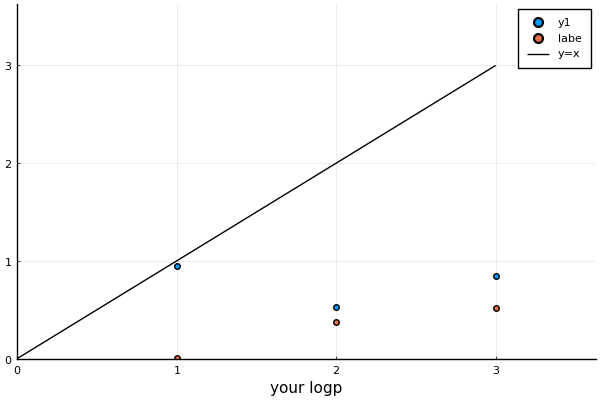

In [52]:
pyplot()
max = maximum(vcat(pval_l[:,1], pval_t[:,1]))
x=collect(0:max)
scatter(pval_l[:,1],xlims=(0,max),ylims=(0,max),xlab="your logp")
scatter!(pval_t[:,1],label="labe")
plot!(x,x,linecolor=:black,label="y=x")

In [6]:
# function calculate_maf(genotype, alleles=2)
#     af_t = sum(genotype, dims=2) ./ (alleles * size(genotype, 2))
#     return replace(x -> x > 0.5 ? 1-x : x, af_t)
# end
# function filter_maf(genotype,maf_threshold)
#     maf = calculate_maf(genotype)
#     if maf_threshold > 0 
#         mask = maf >= maf_threshold
#         genotype = genotype[mask]
# #         variant_ids = variant_id[masks]
#         maf = maf[mask]
#     end
#     return genotype, maf
# end

# def filter_maf(genotype_t, variant_ids, maf_threshold):
#     # """Calculate minor allele frequency"""
#     af_t = genotype_t.sum(1) / (alleles * genotype_t.shape[1])
#     maf_t = torch.where(af_t > 0.5, 1 - af_t, af_t)
#     # """Calculate MAF and filter genotypes that don't pass threshold"""
#     if maf_threshold > 0:
#         mask_t = maf_t >= maf_threshold
#         genotypes_t = genotypes_t[mask_t]
#         variant_ids = variant_ids[mask_t.cpu().numpy().astype(bool)]
#         maf_t = maf_t[mask_t]
#     return genotypes_t, variant_ids,  maf_t


filter_maf (generic function with 1 method)